In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal as randn, multivariate_normal as randmn
import pandas as pd
from algorithms.score_based import *
from algorithms.contrastive_change_point import compute_test_stat_linear
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.cusum import compute_cusum
from consts import *
%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def reference_score(x):
    if isinstance(x, (int, float)):
        return np.array([-x]).reshape(-1, 1)
    return -x.reshape(-1, 1)

In [3]:
def compute_delays_false_alarms(runs, S_list, threshold, tau):
    delays = []
    false_alarms = 0

    for i in range(runs):

        S = S_list[i]
        imin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S, S <= threshold))
        
        if imin - tau <= 0:
            print(imin, i)
            false_alarms += 1
        else:
            delays.append(imin - tau)

    delays = np.array(delays)
    mean_delay = np.round(delays.mean(), 1)
    std_delay = np.round(delays.std(), 1)

    return false_alarms, mean_delay, std_delay

### False alarms and delay time for 1d mean shift 

In [8]:
# score-based cpd

n = 300
tau = 150
runs = 10

sigma = 0.3
eta = 1 / np.sqrt(np.arange(n) + 1)

dim = 1
S_list = np.empty((runs, n))


np.random.seed(1)

for item in range(runs):
    X = sigma * randn(size=n).reshape((n, dim, 1))
    X[tau:] += 3*sigma
    
    model = ChangePointDetector(d_dim=dim, lambda_=0.7, alpha=5e-2, basis=PolyBasis(1, dim), reference_score=reference_score)
    model.run(X, eta)
    S_list[item] = model.test_statistic
# plt.plot(S_list.T)
# plt.show()

threshold = threshold_1d_linear_03
print('threshold = ', threshold)

false_alarms, mean_delay, std_delay = compute_delays_false_alarms(runs, S_list, threshold, tau)
print('Linear basis. False alarms:', false_alarms)
print('Linear basis', mean_delay, '±', std_delay)

threshold =  0.1632
Linear basis. False alarms: 0
Linear basis 3.8 ± 1.5


In [ ]:
# contrastive cpd
np.random.seed(1)

runs = 10
n = 300
tau = 150
sigma = 0.3
mu = 3 * sigma

p = 2
S_poly_list = []
S_nn_list = []

for item in range(10):
    X = sigma * randn(n)
    X[tau:] += mu
    S_poly, _ = compute_test_stat_linear(X, p)
    # S_nn, _ = compute_test_stat_nn(X, n_epochs=50)
    S_poly_list.append(S_poly)
    # S_nn_list.append(S_nn)

# threshold = 
fa_lin, DD_lin, std_DD_lin = compute_delays_false_alarms(runs, S_poly_list, threshold, tau)
        
print('Polynomials. False alarms:', fa_lin)
print('polynomial basis', DD_lin, '±', std_DD_lin)

# threshold = 
# fa_nn, DD_nn, std_DD_nn = compute_delays_false_alarms(runs, S_nn_list, threshold, tau)

# print('Neural networks. False alarms:', fa_nn)
# print('neural network', DD_nn, '±', std_DD_nn)

In [16]:
# fast contrastive cpd
np.random.seed(1)

runs = 10
n = 300
tau = 150
sigma = 0.3
mu = 3 * sigma

p = 2
S_hermite_list = []


for item in range(10):
    X = sigma * randn(size=n)
    X[tau:] += mu
    S_hermite, _ = compute_test_stat_ftal(X, p, beta=0.01, design='hermite')
    S_hermite_list.append(S_hermite)

threshold = threshold_1d_ftal_hermite_03_beta001_p2
fa_herm, DD_herm, std_DD_herm = compute_delays_false_alarms(runs, S_hermite_list, threshold, tau)
        
print('Polynomials. False alarms:', fa_herm)
print('polynomial basis', DD_herm, '±', std_DD_herm)


107 3
Polynomials. False alarms: 1
polynomial basis 3.8 ± 0.9


In [24]:
# kliep, m-stat, cusum

np.random.seed(1)
n = 300
tau = 150
sigma = 0.3
mu = 3 * sigma


S_kliep_list = []
S_mmd_list = []
S_cusum_list = []

for item in range(10):
    X = sigma * randn(size=n)
    X[tau:] += mu

    S_kliep, _ = compute_test_stat_kliep(X, window_size=20, sigma=1)
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.5)
    S_cusum = compute_cusum(X)
    
    S_kliep_list.append(S_kliep)
    S_mmd_list.append(S_mmd)
    S_cusum_list.append(S_cusum)

threshold_kliep = threshold_1d_kliep_03_20_1
fa_kliep, DD_kliep, std_DD_kliep = compute_delays_false_alarms(runs, S_kliep_list, threshold_kliep, tau)
print('KLIEP. False alarms:', fa_kliep)
print('KLIEP', DD_kliep, '±', std_DD_kliep)

threshold_mmd = threshold_1d_mmd_03_20_05
fa_mmd, DD_mmd, std_DD_mmd = compute_delays_false_alarms(runs, S_mmd_list, threshold_mmd, tau)
print('M-statistic. False alarms:', fa_mmd)
print('M-statistic', DD_mmd, '±', std_DD_mmd)

threshold_cusum = threshold_1d_cusum_03
fa_cusum, DD_cusum, std_DD_cusum = compute_delays_false_alarms(runs, S_cusum_list, threshold_cusum, tau)
print('CUSUM. False alarms:', fa_cusum)
print('CUSUM', DD_cusum, '±', std_DD_cusum)



KLIEP. False alarms: 0
KLIEP 7.6 ± 3.1
M-statistic. False alarms: 0
M-statistic 14.8 ± 5.2
40 1
CUSUM. False alarms: 1
CUSUM 2.8 ± 1.4


In [12]:
# quadratic
n = 300
tau = 150
runs = 10

sigma = 0.3
eta = 1 / np.sqrt(np.arange(n) + 1)

dim = 1
S_list = np.empty((runs, n))


np.random.seed(1)

for item in range(runs):
    X = sigma * randn(size=n).reshape((n, dim, 1))
    X[tau:] += 3*sigma
    
    model = ChangePointDetector(d_dim=dim*2, lambda_=2, alpha=1e-4, basis=PolyBasis(2, dim))
    model.run(X, eta)
    S_list[item] = model.test_statistic


# plt.plot(S_list.T)
# plt.show()

S_thrlist = pd.read_csv('thresholds/1d_quadratic_sigma_0.3.csv').to_numpy()
threshold = np.round(np.max(S_thrlist), 4)
print('threshold = ', threshold)


false_alarms, mean_delay, std_delay = compute_delays_false_alarms(runs, S_list, threshold, tau)
print('Quadratic basis. False alarms:', false_alarms)
print('Quadratic basis', mean_delay, '±', std_delay)

threshold =  0.3933
Quadratic basis. False alarms: 0
Quadratic basis 2.0 ± 1.1


### False alarms and delay time for 1d std shift 

In [8]:

n = 300
tau = 150
runs = 10

sigma = 0.3
eta = 1 / np.sqrt(np.arange(n) + 1)

dim = 1
S_list = np.empty((runs, n))


np.random.seed(1)

for item in range(runs):
    X = sigma * randn(size=n).reshape((n, dim, 1))
    X[tau:] *= 3
    
    model = ChangePointDetector(d_dim=dim*2, lambda_=2, alpha=1e-4, basis=PolyBasis(2, dim))
    model.run(X, eta)
    S_list[item] = model.test_statistic


# plt.plot(S_list.T)
# plt.show()

threshold = threshold_1d_quadratic_03

false_alarms, mean_delay, std_delay = compute_delays_false_alarms(runs, S_list, threshold, tau)
print('Poly basis. False alarms:', false_alarms)
print('Poly basis. Delay time:', mean_delay, '±', std_delay)

Poly basis. False alarms: 0
Poly basis. Delay time: 2.5 ± 0.9


In [27]:
# contrastive cpd
np.random.seed(1)

runs = 5
n = 150
tau = 75
sigma = 0.1
# mu = 3 * sigma

p = 3
S_poly_list = []
S_nn_list = []

for item in range(runs):
    X = sigma * randn(size=n)
    X[tau:] *= 3
    S_poly, _ = compute_test_stat_linear(X, p)
    # S_nn, _ = compute_test_stat_nn(X, n_epochs=50)
    S_poly_list.append(S_poly)
    # S_nn_list.append(S_nn)

threshold = threshold_1d_contrastive_linear2_03
fa_lin, DD_lin, std_DD_lin = compute_delays_false_alarms(runs, S_poly_list, threshold, tau)
        
print('Polynomials. False alarms:', fa_lin)
print('polynomial basis', DD_lin, '±', std_DD_lin)

# # threshold = 
# fa_nn, DD_nn, std_DD_nn = compute_delays_false_alarms(runs, S_nn_list, threshold, tau)

# print('Neural networks. False alarms:', fa_nn)
# print('neural network', DD_nn, '±', std_DD_nn)

Polynomials. False alarms: 0
polynomial basis 13.5 ± 5.9


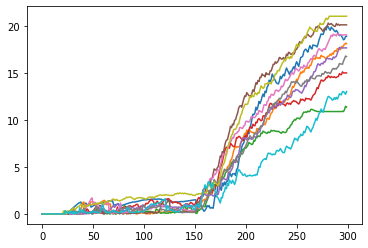

In [65]:
# fast contrastive cpd
np.random.seed(1)

runs = 10
n = 300
tau = 150
sigma = 0.3

p = 3
S_hermite_list = []


for item in range(runs):
    X = sigma * randn(size=n)
    X[tau:] *= 3
    S_hermite, _ = compute_test_stat_ftal(X, p, beta=0.1, design='hermite')
    S_hermite_list.append(S_hermite)

threshold = threshold_1d_ftal_hermite_03_beta01_p3
fa_herm, DD_herm, std_DD_herm = compute_delays_false_alarms(runs, S_hermite_list, threshold, tau)
        
print('Polynomials. False alarms:', fa_herm)
print('polynomial basis', DD_herm, '±', std_DD_herm)

plt.plot(np.array(S_hermite_list).T)


In [66]:
# kliep, m-stat, cusum

np.random.seed(1)
n = 300
tau = 150
sigma = 0.3


S_kliep_list = []
S_mmd_list = []
S_cusum_list = []

for item in range(10):
    X = sigma * randn(size=n)
    X[tau:] *= 3

    S_kliep, _ = compute_test_stat_kliep(X, window_size=20, sigma=1)
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.5)
    S_cusum = compute_cusum(X)
    
    S_kliep_list.append(S_kliep)
    S_mmd_list.append(S_mmd)
    S_cusum_list.append(S_cusum)

threshold_kliep = threshold_1d_kliep_03_20_1
fa_kliep, DD_kliep, std_DD_kliep = compute_delays_false_alarms(runs, S_kliep_list, threshold_kliep, tau)
print('KLIEP. False alarms:', fa_kliep)
print('KLIEP', DD_kliep, '±', std_DD_kliep)

threshold_mmd = threshold_1d_mmd_03_20_05
fa_mmd, DD_mmd, std_DD_mmd = compute_delays_false_alarms(runs, S_mmd_list, threshold_mmd, tau)
print('M-statistic. False alarms:', fa_mmd)
print('M-statistic', DD_mmd, '±', std_DD_mmd)

threshold_cusum = threshold_1d_cusum_03
fa_cusum, DD_cusum, std_DD_cusum = compute_delays_false_alarms(runs, S_cusum_list, threshold_cusum, tau)
print('CUSUM. False alarms:', fa_cusum)
print('CUSUM', DD_cusum, '±', std_DD_cusum)



KLIEP. False alarms: 0
KLIEP 21.8 ± 20.2
M-statistic. False alarms: 0
M-statistic 32.9 ± 36.0
40 1
CUSUM. False alarms: 1
CUSUM 2.6 ± 1.6


### False alarms and delay time for 3d mean shift 

In [4]:
# dim = 3
# n = 300
# tau = 150
# runs = 10

# sigma = 0.3
# mean = np.zeros(dim)
# eta = 1 / np.sqrt(np.arange(n) + 1)


# S_list = np.empty((runs, n))


# np.random.seed(1)

# for item in range(runs):
#     _, cov, _ = np.linalg.svd(randmn(mean=np.zeros(dim), cov=np.eye(dim), size=dim))
#     cov = np.diag(cov) * sigma

#     X = randmn(mean, cov, size=n).reshape((n, dim, 1))

#     X[tau:] += 3*sigma 
    
#     model = ChangePointDetector(d_dim=dim, lambda_=5, alpha=3e-3, basis=PolyBasis(1, dim), reference_score=reference_score)
#     model.run(X, eta)
#     S_list[item] = model.test_statistic


# plt.plot(S_list.T)
# plt.show()

In [72]:

false_alarms, mean_delay, std_delay = compute_delays_false_alarms(runs, S_list, threshold_3d_linear_03_rand, tau)
print('Linear basis. False alarms:', false_alarms)
print('Linear basis', mean_delay, '±', std_delay)

Linear basis. False alarms: 0
Linear basis 31.0 ± 8.4


In [5]:
# dim = 3
# n = 300
# tau = 150
# runs = 10

# sigma = 0.3
# mean = np.zeros(dim)
# cov = np.eye(dim)
# eta = 1 / np.sqrt(np.arange(n) + 1)


# S_list = np.empty((runs, n))


# np.random.seed(1)

# for item in range(runs):
#     # _, cov, _ = np.linalg.svd(randmn(mean=np.zeros(dim), cov=np.eye(dim), size=dim))
#     # cov = np.diag(cov) * sigma

#     X = randmn(mean, cov, size=n).reshape((n, dim, 1)) * sigma

#     X[tau:] += 3*sigma 
    
#     model = ChangePointDetector(d_dim=dim, lambda_=5, alpha=3e-3, basis=PolyBasis(1, dim), reference_score=reference_score)
#     model.run(X, eta)
#     S_list[item] = model.test_statistic


# plt.plot(S_list.T)
# plt.show()

# false_alarms, mean_delay, std_delay = compute_delays_false_alarms(runs, S_list, threshold_3d_linear_03, tau)
# print('Linear basis. False alarms:', false_alarms)
# print('Linear basis', mean_delay, '±', std_delay)

# Linear basis. False alarms: 0
# Linear basis 12.6 ± 3.3

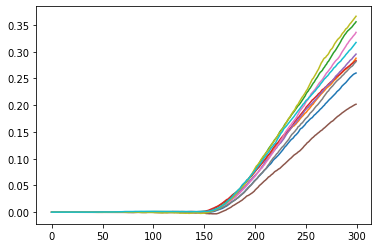

Linear basis. False alarms: 0
Linear basis 8.8 ± 4.4


In [6]:
dim = 3
n = 300
tau = 150
runs = 10

sigma = 0.3
mean = np.zeros(dim)
cov = np.eye(dim)
eta = 1 / np.sqrt(np.arange(n) + 1)


S_list = np.empty((runs, n))


np.random.seed(1)

for item in range(runs):
    # _, cov, _ = np.linalg.svd(randmn(mean=np.zeros(dim), cov=np.eye(dim), size=dim))
    # cov = np.diag(cov) * sigma

    X = randmn(mean, cov, size=n).reshape((n, dim, 1)) * sigma

    X[tau:] += 3*sigma 
    
    model = ChangePointDetector(d_dim=dim, lambda_=30, alpha=5e-4, basis=PolyBasis(1, dim), reference_score=reference_score)
    model.run(X, eta)
    S_list[item] = model.test_statistic


plt.plot(S_list.T)
plt.show()

false_alarms, mean_delay, std_delay = compute_delays_false_alarms(runs, S_list, threshold_3d_linear_03_30, tau)
print('Linear basis. False alarms:', false_alarms)
print('Linear basis', mean_delay, '±', std_delay)

- quadratic 
- cov = diag([0.1, 0.1, 0.1])
- mean = 0
- threshold = 48.2317
- lambda = 0.8
- alpha = 5e-8
- shift = 0.3
- fa = 0
- delay 1.5 ± 0.9

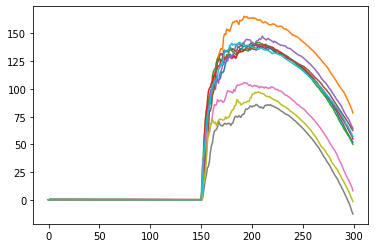

In [15]:
#quadratic 


dim = 3
n = 300
tau = 150
runs = 10

sigma = 0.3
mean = np.zeros(dim)
cov = np.eye(dim)
eta = 1 / np.sqrt(np.arange(n) + 1)


S_list = np.empty((runs, n))


np.random.seed(1)

for item in range(runs):
    # _, s, _ = np.linalg.svd(randmn(mean=np.ones(dim), cov=np.eye(dim), size=dim))
    # cov = np.diag(s) * sigma
    # print(cov)

    X = randmn(mean, cov, size=n).reshape((n, dim, 1)) * sigma
    X[tau:] += 3*sigma
    
    model = ChangePointDetector(dim*2, lambda_= 5, alpha=5e-5, basis=PolyBasis(2, dim)) 
    model.run(X, eta)
    S_list[item] = model.test_statistic


plt.plot(S_list.T)
plt.show()



In [16]:
false_alarms, mean_delay, std_delay = compute_delays_false_alarms(runs, S_list, threshold_3d_quadratic_03, tau)

print('Quadratic basis. False alarms:', false_alarms)
print('Quadratic basis', mean_delay, '±', std_delay)

Quadratic basis. False alarms: 0
Quadratic basis 1.1 ± 0.3


In [25]:
# fast contrastive cpd
np.random.seed(1)

runs = 10
n = 300
tau = 150

sigma = 0.3
mean = np.zeros(dim)
cov = np.eye(dim)

# p = 2
S_ftal_list = np.empty((runs, n))


for item in range(runs):
    X = randmn(mean, cov, size=n) * sigma
    X[tau:] += 3*sigma 
    
    S_ftal, _ = compute_test_stat_ftal(X, beta=0.0001, design='multivariate')
    S_ftal_list[item] = S_ftal





NameError: name 'S_list' is not defined

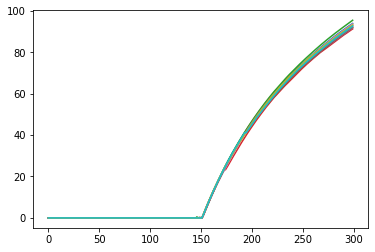

146 2
Polynomials. False alarms: 1
polynomial basis 2.0 ± 0.0


In [26]:
plt.plot(S_ftal_list.T)
plt.show()

threshold = threshold_3d_ftal_03_1e4
fa_ftal, DD_ftal, std_DD_ftal = compute_delays_false_alarms(runs, S_ftal_list, threshold, tau)
        
print('Polynomials. False alarms:', fa_ftal)
print('polynomial basis', DD_ftal, '±', std_DD_ftal)


In [100]:
from consts import *

In [102]:
# kliep, m-stat, cusum

np.random.seed(1)

runs = 10
n = 300
tau = 150
sigma = 0.3
mean = np.zeros(dim)
cov = np.eye(dim)

S_kliep_list = np.empty((runs, n))
S_mmd_list = np.empty((runs, n))

for item in range(runs):
    X = randmn(mean, cov, size=n) * sigma
    X[tau:] += 3*sigma

    S_kliep, _ = compute_test_stat_kliep(X, window_size=20, sigma=2)
    S_kliep_list[item] = S_kliep

    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=4)
    S_mmd_list[item] = S_mmd




fa_kliep, DD_kliep, std_DD_kliep = compute_delays_false_alarms(runs, S_kliep_list, threshold_3d_kliep_03_2, tau)
        
print('Polynomials. False alarms:', fa_kliep)
print('polynomial basis', DD_kliep, '±', std_DD_kliep)



fa_mmd, DD_mmd, std_DD_mmd = compute_delays_false_alarms(runs, S_mmd_list, threshold_3d_mmd_03_4, tau)
        
print('Polynomials. False alarms:', fa_mmd)
print('polynomial basis', DD_mmd, '±', std_DD_mmd)



Polynomials. False alarms: 0
polynomial basis 4.9 ± 1.7
56 9
Polynomials. False alarms: 1
polynomial basis 4.7 ± 1.2


### False alarms and delay time for 3d cov matrix shift

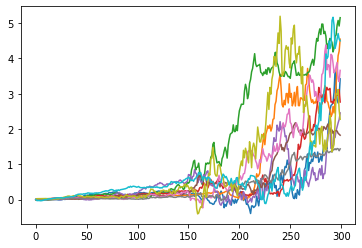

Linear basis. False alarms: 0
Linear basis 78.1 ± 33.4


In [103]:
dim = 3
n = 300
tau = 150
runs = 10

sigma = 0.3
mean = np.zeros(dim)
eta = 1 / np.sqrt(np.arange(n) + 1)


S_list = np.empty((runs, n))


np.random.seed(1)

for item in range(runs):
    _, cov, _ = np.linalg.svd(randmn(mean=np.zeros(dim), cov=np.eye(dim), size=dim))
    cov = np.diag(cov) * sigma

    X = randmn(mean, cov, size=n).reshape((n, dim, 1))

    X[tau:] *= 3
    
    model = ChangePointDetector(d_dim=dim, lambda_=5, alpha=3e-3, basis=PolyBasis(1, dim), reference_score=reference_score)
    model.run(X, eta)
    S_list[item] = model.test_statistic


plt.plot(S_list.T)
plt.show()

false_alarms, mean_delay, std_delay = compute_delays_false_alarms(runs, S_list, threshold_3d_linear_03_rand, tau)
print('Linear basis. False alarms:', false_alarms)
print('Linear basis', mean_delay, '±', std_delay)

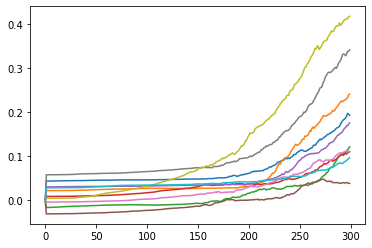

TypeError: cannot unpack non-iterable NoneType object

In [113]:
dim = 3
n = 300
tau = 150
runs = 10

sigma = 0.3
mean = np.zeros(dim)
cov = np.eye(dim)
eta = 1 / np.sqrt(np.arange(n) + 1)


S_list = np.empty((runs, n))


np.random.seed(1)

for item in range(runs):
    # _, cov, _ = np.linalg.svd(randmn(mean=np.zeros(dim), cov=np.eye(dim), size=dim))
    # cov = np.diag(cov) * sigma

    X = randmn(mean, cov, size=n).reshape((n, dim, 1)) * sigma

    X[tau:] *=  3
    
    model = ChangePointDetector(d_dim=dim, lambda_=1, alpha=5e-5, basis=PolyBasis(1, dim), reference_score=reference_score)
    model.run(X, eta)
    S_list[item] = model.test_statistic


plt.plot(S_list.T)
plt.show()

false_alarms, mean_delay, std_delay = compute_delays_false_alarms(runs, S_list, 0.1163, tau)
print('Linear basis. False alarms:', false_alarms)
print('Linear basis', mean_delay, '±', std_delay)


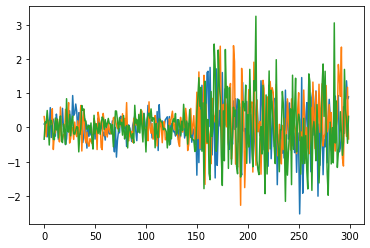

In [110]:
plt.plot(X[:, 0, 0].T)
plt.plot(X[:, 1, 0].T)
plt.plot(X[:, 2, 0].T)

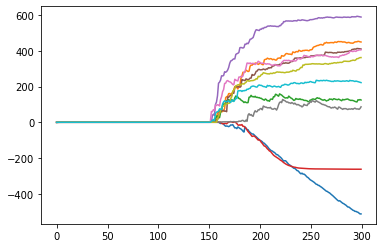

1 2
Quadratic basis. False alarms: 1
Quadratic basis 4.6 ± 3.7


In [114]:
#quadratic 


dim = 3
n = 300
tau = 150
runs = 10

sigma = 0.3
mean = np.zeros(dim)
cov = np.eye(dim)
eta = 1 / np.sqrt(np.arange(n) + 1)


S_list = np.empty((runs, n))


np.random.seed(1)

for item in range(runs):
    _, cov, _ = np.linalg.svd(randmn(mean=np.zeros(dim), cov=np.eye(dim), size=dim))
    cov = np.diag(cov)

    X = randmn(mean, cov, size=n).reshape((n, dim, 1)) * sigma

    X[tau:] *= 3 
    
    model = ChangePointDetector(dim*2, lambda_= 5, alpha=5e-5, basis=PolyBasis(2, dim)) 
    model.run(X, eta)
    S_list[item] = model.test_statistic


plt.plot(S_list.T)
plt.show()

false_alarms, mean_delay, std_delay = compute_delays_false_alarms(runs, S_list, threshold_3d_quadratic_03, tau)
print('Quadratic basis. False alarms:', false_alarms)
print('Quadratic basis', mean_delay, '±', std_delay)

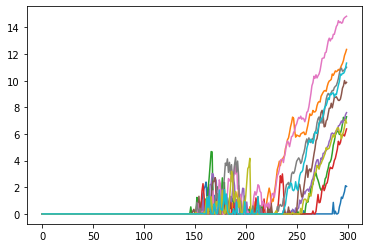

146 2
Polynomials. False alarms: 1
polynomial basis 5.2 ± 3.8


In [23]:
# fast contrastive cpd
np.random.seed(1)

dim = 3
runs = 10
n = 300
tau = 150

sigma = 0.3
mean = np.zeros(dim)
cov = np.eye(dim)

# p = 1
S_ftal_list = np.empty((runs, n))


for item in range(runs):
    X = randmn(mean, cov, size=n) * sigma
    X[tau:] *= 3 
    
    S_ftal, _ = compute_test_stat_ftal(X, beta=1e-4, design='multivariate')
    S_ftal_list[item] = S_ftal



plt.plot(S_ftal_list.T)
plt.show()

threshold = threshold_3d_ftal_03_1e4
fa_ftal, DD_ftal, std_DD_ftal = compute_delays_false_alarms(runs, S_ftal_list, threshold, tau)
        
print('Polynomials. False alarms:', fa_ftal)
print('polynomial basis', DD_ftal, '±', std_DD_ftal)



In [24]:
# kliep, m-stat, cusum

np.random.seed(1)

runs = 10
n = 300
tau = 150
sigma = 0.3
mean = np.zeros(dim)
cov = np.eye(dim)

S_kliep_list = np.empty((runs, n))
S_mmd_list = np.empty((runs, n))

for item in range(runs):
    X = randmn(mean, cov, size=n) * sigma
    X[tau:] *= 3

    S_kliep, _ = compute_test_stat_kliep(X, window_size=20, sigma=2)
    S_kliep_list[item] = S_kliep

    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=4)
    S_mmd_list[item] = S_mmd




fa_kliep, DD_kliep, std_DD_kliep = compute_delays_false_alarms(runs, S_kliep_list, threshold_3d_kliep_03_2, tau)
        
print('Polynomials. False alarms:', fa_kliep)
print('polynomial basis', DD_kliep, '±', std_DD_kliep)



fa_mmd, DD_mmd, std_DD_mmd = compute_delays_false_alarms(runs, S_mmd_list, threshold_3d_mmd_03_4, tau)
        
print('Polynomials. False alarms:', fa_mmd)
print('polynomial basis', DD_mmd, '±', std_DD_mmd)



Polynomials. False alarms: 0
polynomial basis 30.1 ± 9.1
56 9
Polynomials. False alarms: 1
polynomial basis 12.1 ± 3.4
